In [3]:

import zipfile


In [4]:
import os

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.diagnostic import linear_rainbow, het_breuschpagan
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.preprocessing import LabelEncoder

## Import Data

In [1]:
! wget -P ../../data/raw https://aqua.kingcounty.gov/extranet/assessor/Real%20Property%20Sales.zip
! wget -P ../../data/raw https://aqua.kingcounty.gov/extranet/assessor/Residential%20Building.zip

/bin/sh: wget: command not found
/bin/sh: wget: command not found


In [1]:
! which wget


wget not found


In [3]:
with zipfile.ZipFile('../../data/raw/Parcel.zip', 'r') as zip_ref:
    zip_ref.extractall('../../data/raw')
with zipfile.ZipFile('../../data/raw/Real Property Sales.zip', 'r') as zip_ref:
    zip_ref.extractall('../../data/raw')
with zipfile.ZipFile('../../data/raw/Residential Building.zip', 'r') as zip_ref:
    zip_ref.extractall('../../data/raw')

NameError: name 'zipfile' is not defined

In [30]:
parcel = pd.read_csv("../../data/raw/EXTR_Parcel.csv", encoding='latin-1')
real_property_sales = pd.read_csv("../../data/raw/EXTR_RPSale.csv", encoding='latin-1', low_memory=False)
residential_building = pd.read_csv("../../data/raw/EXTR_ResBldg.csv", encoding='latin-1', low_memory=False)

In [191]:
residential_building.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517783 entries, 0 to 517782
Data columns (total 7 columns):
 #   Column             Non-Null Count   Dtype
---  ------             --------------   -----
 0   Major              517783 non-null  int64
 1   Minor              517783 non-null  int64
 2   NbrLivingUnits     517783 non-null  int64
 3   SqFtTotLiving      517783 non-null  int64
 4   SqFtOpenPorch      517783 non-null  int64
 5   SqFtEnclosedPorch  517783 non-null  int64
 6   Has_Porch          517783 non-null  int64
dtypes: int64(7)
memory usage: 27.7 MB


## Clean Data and Filter For Needed Info

In [31]:
# Real Property Sales
# Identifyers are Major and Minor. Relevant data is SalePrice
# Clean real_property_sales to have proper values in Minor and Major and change type to int to match other data sets
real_property_sales = real_property_sales[['Major', 'Minor', 'SalePrice', 'DocumentDate']]
real_property_sales = real_property_sales[(real_property_sales['Major'].str.isdecimal()==True) &
                                          (real_property_sales['Minor'].str.isdecimal()==True)]
real_property_sales['Major'] = real_property_sales['Major'].astype('int64')
real_property_sales['Minor'] = real_property_sales['Minor'].astype('int64')
real_property_sales = real_property_sales[real_property_sales['SalePrice']>0]

In [32]:
real_property_sales.head()

,Major,Minor,SalePrice,DocumentDate
0,138860,110,245000,08/21/2014
4,213043,120,560000,12/20/2019
5,951120,900,85000,04/20/1989
7,122209,9002,5755000,04/25/2001
8,122209,9001,5755000,04/25/2001


In [33]:
# Parcel Filter for Necessary Columns
parcel = parcel[['Major', 'Minor', 'SqFtLot', 'WfntLocation', 'TrafficNoise', 'AirportNoise', 'PowerLines', 'OtherNuisances']]
parcel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 616089 entries, 0 to 616088
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   Major           616089 non-null  int64 
 1   Minor           616089 non-null  int64 
 2   SqFtLot         616089 non-null  int64 
 3   WfntLocation    616089 non-null  int64 
 4   TrafficNoise    616089 non-null  int64 
 5   AirportNoise    616089 non-null  int64 
 6   PowerLines      616089 non-null  object
 7   OtherNuisances  616089 non-null  object
dtypes: int64(6), object(2)
memory usage: 37.6+ MB


In [34]:
# Residential Buiding Filter For Necessary Columns
residential_building = residential_building[['Major', 'Minor', 'NbrLivingUnits', 'SqFtTotLiving', 'SqFtOpenPorch', 'SqFtEnclosedPorch']]

In [35]:
# Create a column Has_Porch
residential_building['Has_Porch']= residential_building['SqFtOpenPorch'] + residential_building['SqFtEnclosedPorch']
residential_building['Has_Porch'] = [1  if p>0 else 0 for p in residential_building['Has_Porch']]

In [36]:
residential_building.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517783 entries, 0 to 517782
Data columns (total 7 columns):
 #   Column             Non-Null Count   Dtype
---  ------             --------------   -----
 0   Major              517783 non-null  int64
 1   Minor              517783 non-null  int64
 2   NbrLivingUnits     517783 non-null  int64
 3   SqFtTotLiving      517783 non-null  int64
 4   SqFtOpenPorch      517783 non-null  int64
 5   SqFtEnclosedPorch  517783 non-null  int64
 6   Has_Porch          517783 non-null  int64
dtypes: int64(7)
memory usage: 27.7 MB


In [37]:
# Join all the tables on Major, Minor
# Have duplicate buildings sold at different dates. Need to only keep latest dates
merged_tables = real_property_sales.merge(parcel).merge(residential_building).drop_duplicates()
# Change dates to date time format
merged_tables['DocumentDate'] = pd.to_datetime(merged_tables['DocumentDate'])

In [38]:
#Keeping only the most recent Sale_Price
buildings_df = merged_tables.sort_values('DocumentDate').drop_duplicates(['Major', 'Minor'],keep='first')

In [39]:
df_test = buildings_df.sort_values('DocumentDate')
df_test

,Major,Minor,SalePrice,DocumentDate,SqFtLot,WfntLocation,TrafficNoise,AirportNoise,PowerLines,OtherNuisances,NbrLivingUnits,SqFtTotLiving,SqFtOpenPorch,SqFtEnclosedPorch,Has_Porch
705940,514510,250,125000,1934-11-11,7041,0,0,0,N,N,1,910,0,0,0
443490,718680,30,600,1954-03-11,9345,0,0,0,N,N,1,1380,40,0,1
653999,245840,30,9500,1955-04-15,6300,0,1,0,N,N,1,820,0,0,0
962419,222470,151,12250,1959-10-10,11115,0,1,0,N,N,1,2090,0,0,0
235295,503180,251,2300,1960-09-27,19064,3,0,0,N,N,1,1140,40,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
900477,241990,45,642000,2020-09-08,11054,0,0,0,N,N,1,1510,0,0,0
366504,327530,150,393000,2020-09-09,9500,0,0,0,N,N,1,1250,110,0,1
925600,797260,2865,590000,2020-09-09,10275,0,0,0,N,N,1,1660,40,0,1
960304,330070,280,535000,2020-09-09,4000,0,0,0,N,N,1,700,0,0,0


In [77]:
# Check x if have the relevant data to answer question
# [x]Higher square footage increases home sale price1, 2
# [x]Having a porch increases home sale price3, 4
# [x]Having a beachfront or lakefront increases home sale price5
# [x]The house filling a higher proportion of the overall lot decreases home sale price6
# [x]The cost per square foot is lower in duplexes than in single-family homes7
# [x]The presence of a nuisance (power lines, traffic noise, airport noise) decreases home sale price1, 5

## Graphical EDA

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

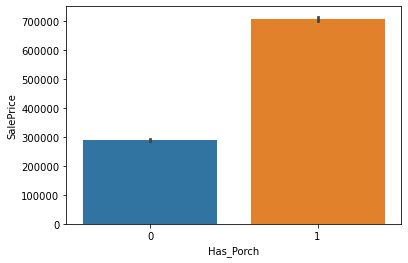

In [14]:
sns.barplot(df['Has_Porch'], df['SalePrice']);




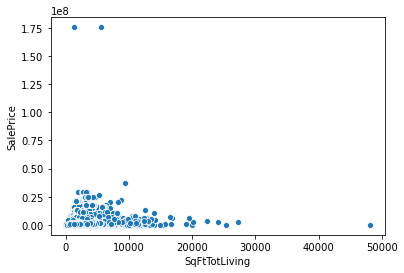

In [15]:
sns.scatterplot(df['SqFtTotLiving'], df['SalePrice']);




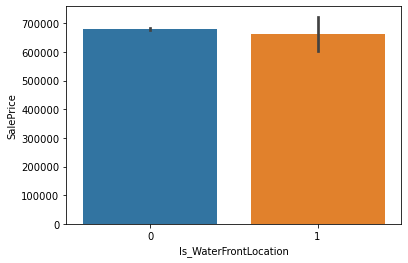

In [64]:
sns.barplot(df['Is_WaterFrontLocation'], df['SalePrice']);

In [5]:
df = pd.read_csv('../../data/clean/KingCountyHousingData.csv')
df.head()


,Unnamed: 0,Major,Minor,ZipCode,DocumentDate,SalePrice,SqFtLot,SqFtTotLiving,Nuisances,Has_Nuisance,...,NbrLivingUnits,View_MtRainier,View_Olympics,View_Cascades,View_PugetSound,View_LakeWashington,View_LakeSammamish,View_SmallLakeRiverCreek,BldgGrade,Has_Deck
0,0,100,67,98002,2019-04-01,310800,17400,2240,No Nuisances,0,...,1,0,0,0,0,0,0,0,6,0
1,1,100,66,98002,2019-10-22,339000,14500,1200,No Nuisances,0,...,1,0,0,0,0,0,0,0,5,0
2,2,100,42,98002,2019-10-29,485500,6002,2134,No Nuisances,0,...,1,0,0,0,0,0,0,0,5,0
3,3,120,8,98166,2019-05-17,850000,24142,3500,No Nuisances,0,...,1,0,0,0,0,0,0,0,6,1
4,4,140,27,98178,2019-05-28,535000,14208,2170,Traffic Noise,1,...,1,0,0,0,0,0,0,0,5,1


In [207]:
#df.hist(figsize=(18,15), bins='auto');

In [6]:
df_water_dummie =pd.get_dummies(df['WaterFrontLocation'])
df_water_dummie.drop('None', axis= 1, inplace=True)
#df_water_dummie['SqFtTotLiving'] = df.SqFtTotLiving
df_water_dummie


,Duwamish,Lake Sammamish,Lake Union,Lake Washington,Other lake,Puget Sound,River or slough,Ship Canal
0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
27723,0,0,0,0,0,0,0,0
27724,0,0,0,0,0,0,0,0
27725,0,0,0,0,0,0,0,0
27726,0,0,0,0,0,0,0,0


In [7]:
from sklearn.linear_model import LinearRegression



In [210]:
lr = LinearRegression()
lr.fit(df_water_dummie, df['SalePrice'])
#lr.__dict__


LinearRegression()

In [211]:
lr.score(df_water_dummie, df['SalePrice'])



0.39382491267103936

In [212]:
lr.coef_



array([-8.64230198e+03,  1.82451159e+06,  3.66917232e+05,  2.08094891e+06,
        3.48825330e+04,  4.17368854e+05,  4.61416527e+04,  8.82451221e+05,
        3.35148305e+02])

In [213]:
for col, coef in zip(list(df_water_dummie), lr.coef_):
    print(col,coef)


Duwamish -8642.301984721033
Lake Sammamish 1824511.5948370975
Lake Union 366917.232058954
Lake Washington 2080948.9118916402
Other lake 34882.53301025234
Puget Sound 417368.85403985356
River or slough 46141.652652212695
Ship Canal 882451.2212115147
SqFtTotLiving 335.148304847272


## Concatinate the two data frames

In [8]:
comb_df = pd.concat([df, df_water_dummie], axis=1)
comb_df.head()

,Unnamed: 0,Major,Minor,ZipCode,DocumentDate,SalePrice,SqFtLot,SqFtTotLiving,Nuisances,Has_Nuisance,...,BldgGrade,Has_Deck,Duwamish,Lake Sammamish,Lake Union,Lake Washington,Other lake,Puget Sound,River or slough,Ship Canal
0,0,100,67,98002,2019-04-01,310800,17400,2240,No Nuisances,0,...,6,0,0,0,0,0,0,0,0,0
1,1,100,66,98002,2019-10-22,339000,14500,1200,No Nuisances,0,...,5,0,0,0,0,0,0,0,0,0
2,2,100,42,98002,2019-10-29,485500,6002,2134,No Nuisances,0,...,5,0,0,0,0,0,0,0,0,0
3,3,120,8,98166,2019-05-17,850000,24142,3500,No Nuisances,0,...,6,1,0,0,0,0,0,0,0,0
4,4,140,27,98178,2019-05-28,535000,14208,2170,Traffic Noise,1,...,5,1,0,0,0,0,0,0,0,0


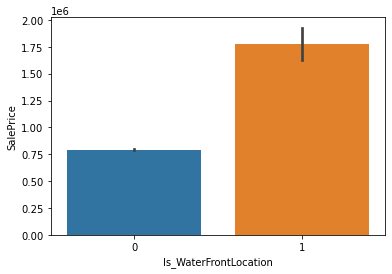

In [229]:
sns.barplot(df['Is_WaterFrontLocation'], df['SalePrice']);



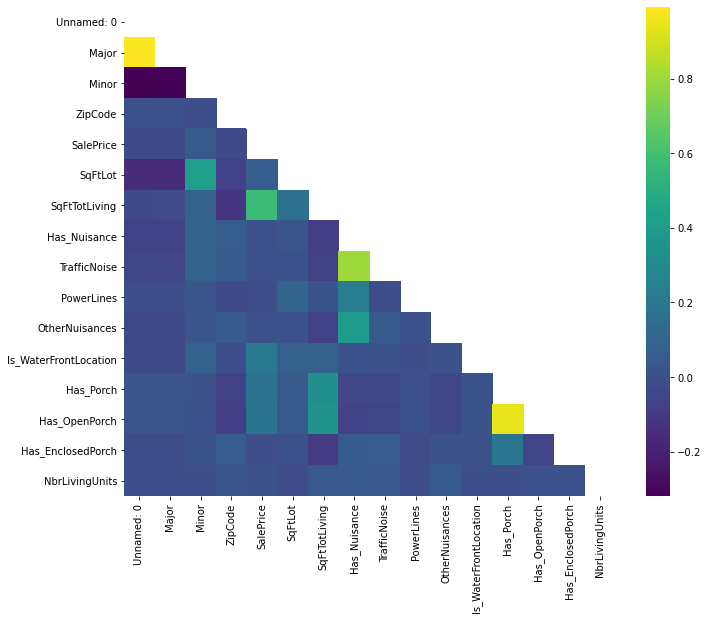

In [215]:
corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))

fig1, ax1 = plt.subplots(figsize=(11, 9))
sns.heatmap(corr, mask=mask, ax=ax1, cmap="viridis");



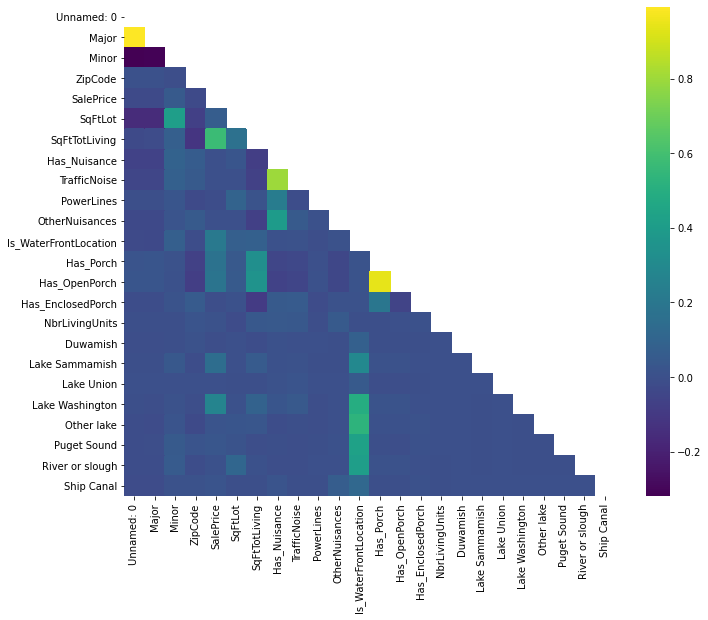

In [233]:
corr = comb_df.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))

fig1, ax1 = plt.subplots(figsize=(11, 9))
sns.heatmap(corr, mask=mask, ax=ax1, cmap="viridis");

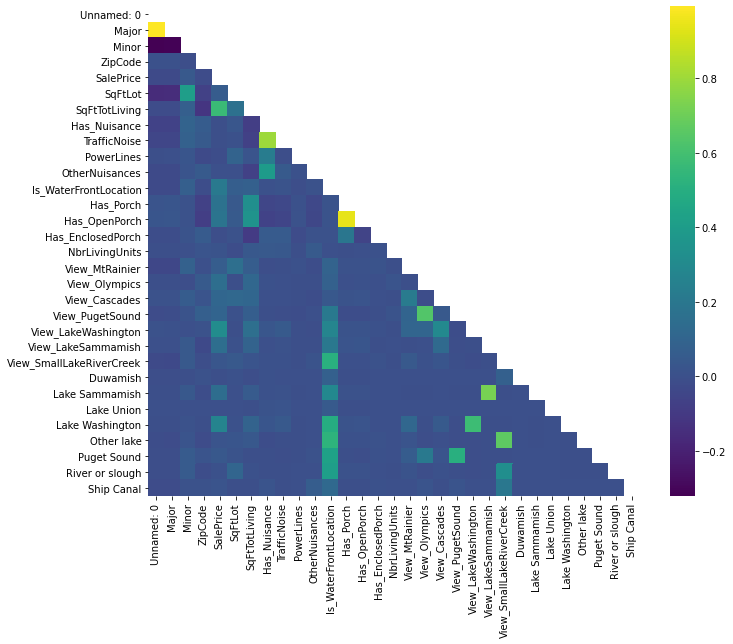

In [348]:
corr = comb_df.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))

fig1, ax1 = plt.subplots(figsize=(11, 9))
sns.heatmap(corr, mask=mask, ax=ax1, cmap="viridis");

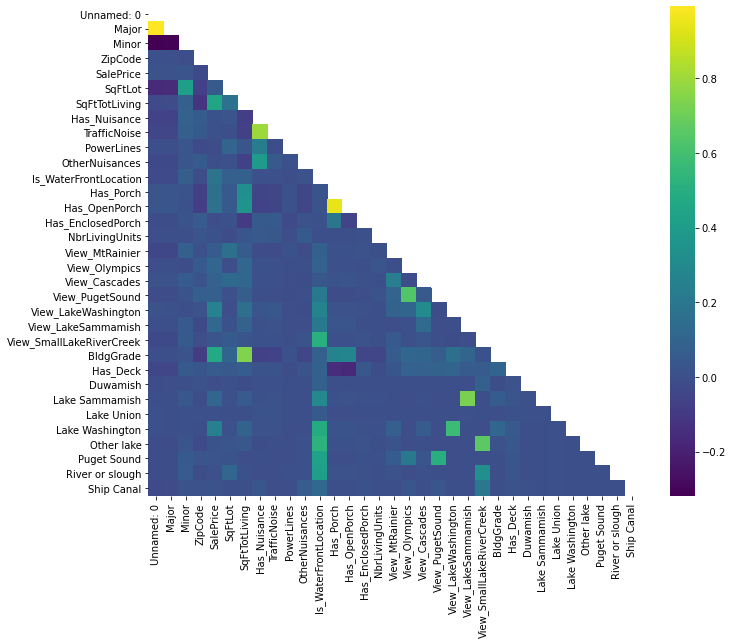

In [466]:
corr = comb_df.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))

fig1, ax1 = plt.subplots(figsize=(11, 9))
sns.heatmap(corr, mask=mask, ax=ax1, cmap="viridis");
plt.

## EDA simple models


In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.formula.api import ols
%matplotlib inline

### FSM_Model 1

In [113]:
outcome = 'SalePrice'
x_cols = ['SqFtTotLiving']

In [115]:
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
fsm_model = ols(formula=formula, data=df).fit()
fsm_model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.357
Model:                            OLS   Adj. R-squared:                  0.357
Method:                 Least Squares   F-statistic:                 1.603e+04
Date:                Tue, 29 Sep 2020   Prob (F-statistic):               0.00
Time:                        13:04:10   Log-Likelihood:            -4.1190e+05
No. Observations:               28824   AIC:                         8.238e+05
Df Residuals:                   28822   BIC:                         8.238e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      1.106e+05   5757.098     19.217      0.000    9.93e+04    1.22e+05
SqFtTotLiving   306.1794      2.419    126.597      0.000     301.439     310.920
==============================================================================
Omnibus:                    13104.282   Durbin-Watson:                   1.918
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           110455.449
Skew:                           1.996   Prob(JB):                         0.00
Kurtosis:                      11.720   Cond. No.                     5.98e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.98e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### FSM_Model 2

In [111]:
outcome = 'SalePrice'
x_cols = ['Has_Porch']

In [112]:
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
fsm_model = ols(formula=formula, data=df).fit()
fsm_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.043
Model:                            OLS   Adj. R-squared:                  0.043
Method:                 Least Squares   F-statistic:                     1287.
Date:                Tue, 29 Sep 2020   Prob (F-statistic):          9.26e-276
Time:                        13:01:19   Log-Likelihood:            -4.1765e+05
No. Observations:               28824   AIC:                         8.353e+05
Df Residuals:                   28822   BIC:                         8.353e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   6.667e+05   4202.924    158.627      0.000    6.58e+05    6.75e+05
Has_Porch    2.02e+05   5630.090     35.873      0.000    1.91e+05    2.13e+05
==============================================================================
Omnibus:                    13917.537   Durbin-Watson:                   1.947
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            91641.326
Skew:                           2.256   Prob(JB):                         0.00
Kurtosis:                      10.480   Cond. No.                         2.77
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### FSM_Model 3

In [116]:
outcome = 'SalePrice'
x_cols = ['Is_WaterFrontLocation']


In [117]:
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
fsm_model = ols(formula=formula, data=df).fit()
fsm_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     543.6
Date:                Tue, 29 Sep 2020   Prob (F-statistic):          3.96e-119
Time:                        13:06:08   Log-Likelihood:            -4.1801e+05
No. Observations:               28824   AIC:                         8.360e+05
Df Residuals:                   28822   BIC:                         8.360e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept              7.713e+05   2852.292    270.404      0.000    7.66e+05    7.77e+05
Is_WaterFrontLocation  5.542e+05   2.38e+04     23.315      0.000    5.08e+05    6.01e+05
==============================================================================
Omnibus:                    13630.220   Durbin-Watson:                   1.943
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            85827.233
Skew:                           2.217   Prob(JB):                         0.00
Kurtosis:                      10.198   Cond. No.                         8.40
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### FSM_Model 4

In [120]:
outcome = 'SalePrice'
x_cols = ['Has_Nuisance']

In [121]:
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
fsm_model = ols(formula=formula, data=df).fit()
fsm_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.043
Date:                Tue, 29 Sep 2020   Prob (F-statistic):              0.307
Time:                        13:09:15   Log-Likelihood:            -4.1827e+05
No. Observations:               28824   AIC:                         8.366e+05
Df Residuals:                   28822   BIC:                         8.366e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     7.779e+05   3137.880    247.915      0.000    7.72e+05    7.84e+05
Has_Nuisance  7765.3750   7603.559      1.021      0.307   -7137.952    2.27e+04
==============================================================================
Omnibus:                    14136.291   Durbin-Watson:                   1.947
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            92644.887
Skew:                           2.303   Prob(JB):                         0.00
Kurtosis:                      10.478   Cond. No.                         2.75
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### FSM_Model 5

In [124]:
outcome = 'SalePrice'
x_cols = ['SqFtLot']

In [125]:
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
fsm_model = ols(formula=formula, data=df).fit()
fsm_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     147.2
Date:                Tue, 29 Sep 2020   Prob (F-statistic):           8.65e-34
Time:                        13:12:40   Log-Likelihood:            -4.1820e+05
No. Observations:               28824   AIC:                         8.364e+05
Df Residuals:                   28822   BIC:                         8.364e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   7.606e+05   3239.580    234.779      0.000    7.54e+05    7.67e+05
SqFtLot        1.4735      0.121     12.132      0.000       1.235       1.712
==============================================================================
Omnibus:                    14076.440   Durbin-Watson:                   1.947
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            92185.738
Skew:                           2.291   Prob(JB):                         0.00
Kurtosis:                      10.467   Cond. No.                     3.03e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.03e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Multilinear Models


### ML_Model 1

In [234]:
outcome = 'SalePrice'
x_cols = ['SqFtTotLiving','Has_Porch' ]


In [236]:
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
ml_model1 = ols(formula=formula, data=df).fit()
ml_model1.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.330
Model:                            OLS   Adj. R-squared:                  0.330
Method:                 Least Squares   F-statistic:                     6822.
Date:                Tue, 29 Sep 2020   Prob (F-statistic):               0.00
Time:                        19:42:35   Log-Likelihood:            -4.0289e+05
No. Observations:               27728   AIC:                         8.058e+05
Df Residuals:                   27725   BIC:                         8.058e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      3.764e+04   7373.289      5.105      0.000    2.32e+04    5.21e+04
SqFtTotLiving   353.4087      3.181    111.086      0.000     347.173     359.644
Has_Porch     -1.431e+04   6330.603     -2.261      0.024   -2.67e+04   -1904.546
==============================================================================
Omnibus:                    28674.977   Durbin-Watson:                   1.027
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          3431705.698
Skew:                           4.954   Prob(JB):                         0.00
Kurtosis:                      56.592   Cond. No.                     6.19e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.19e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### ML_Model 2

In [141]:
outcome = 'SalePrice'
x_cols = ['SqFtTotLiving','Has_Porch', 'Is_WaterFrontLocation']


In [155]:
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
ml_model2 = ols(formula=formula, data=df).fit()
ml_model2.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.370
Model:                            OLS   Adj. R-squared:                  0.370
Method:                 Least Squares   F-statistic:                     5639.
Date:                Tue, 29 Sep 2020   Prob (F-statistic):               0.00
Time:                        13:38:21   Log-Likelihood:            -4.1162e+05
No. Observations:               28824   AIC:                         8.232e+05
Df Residuals:                   28820   BIC:                         8.233e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept              1.079e+05   5763.462     18.716      0.000    9.66e+04    1.19e+05
SqFtTotLiving           302.5124      2.543    118.947      0.000     297.528     307.497
Has_Porch              7563.4853   4847.244      1.560      0.119   -1937.338    1.71e+04
Is_WaterFrontLocation  4.555e+05   1.91e+04     23.894      0.000    4.18e+05    4.93e+05
==============================================================================
Omnibus:                    12545.159   Durbin-Watson:                   1.915
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           102534.109
Skew:                           1.901   Prob(JB):                         0.00
Kurtosis:                      11.422   Cond. No.                     2.00e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large,  2e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [382]:
comb_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27814 entries, 0 to 27813
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Unnamed: 0                27814 non-null  int64 
 1   Major                     27814 non-null  int64 
 2   Minor                     27814 non-null  int64 
 3   ZipCode                   27814 non-null  int64 
 4   DocumentDate              27814 non-null  object
 5   SalePrice                 27814 non-null  int64 
 6   SqFtLot                   27814 non-null  int64 
 7   SqFtTotLiving             27814 non-null  int64 
 8   Nuisances                 27814 non-null  object
 9   Has_Nuisance              27814 non-null  int64 
 10  TrafficNoise              27814 non-null  int64 
 11  PowerLines                27814 non-null  int64 
 12  OtherNuisances            27814 non-null  int64 
 13  Is_WaterFrontLocation     27814 non-null  int64 
 14  WaterFrontLocation    

In [10]:
comb_df = comb_df.rename(columns={"Other lake": "Other_lake","Lake Sammamish":"Lake_Sammamish", "Lake Union": "Lake_Union", "Lake Washington": "Lake_Washington", "Puget Sound": "Puget_Sound", "River or slough":"River_or_slough", "Ship Canal": "Ship_Canal" })

In [11]:
comb_df.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27728 entries, 0 to 27727
Data columns (total 36 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Unnamed: 0                27728 non-null  int64 
 1   Major                     27728 non-null  int64 
 2   Minor                     27728 non-null  int64 
 3   ZipCode                   27728 non-null  int64 
 4   DocumentDate              27728 non-null  object
 5   SalePrice                 27728 non-null  int64 
 6   SqFtLot                   27728 non-null  int64 
 7   SqFtTotLiving             27728 non-null  int64 
 8   Nuisances                 27728 non-null  object
 9   Has_Nuisance              27728 non-null  int64 
 10  TrafficNoise              27728 non-null  int64 
 11  PowerLines                27728 non-null  int64 
 12  OtherNuisances            27728 non-null  int64 
 13  Is_WaterFrontLocation     27728 non-null  int64 
 14  WaterFrontLocation    

### ML_Model 3 --water

In [326]:
outcome = 'SalePrice'
x_cols = ['SqFtTotLiving','Duwamish', 'Lake_Sammamish', 'Lake_Union', 'Lake_Union', 'Lake_Washington', 'Other_lake','Puget_Sound', 'River_or_slough', 'Ship_Canal']


In [327]:
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
ml_model3 = ols(formula=formula, data=comb_df).fit()
ml_model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.394
Model:                            OLS   Adj. R-squared:                  0.394
Method:                 Least Squares   F-statistic:                     2001.
Date:                Tue, 29 Sep 2020   Prob (F-statistic):               0.00
Time:                        20:36:02   Log-Likelihood:            -4.0150e+05
No. Observations:               27728   AIC:                         8.030e+05
Df Residuals:                   27718   BIC:                         8.031e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        5.663e+04   6932.048      8.169      0.000     4.3e+04    7.02e+04
SqFtTotLiving     335.1483      2.877    116.486      0.000     329.509     340.788
Duwamish        -8642.3020   2.72e+05     -0.032      0.975   -5.41e+05    5.24e+05
Lake_Sammamish   1.825e+06   7.36e+04     24.787      0.000    1.68e+06    1.97e+06
Lake_Union       3.669e+05    4.7e+05      0.780      0.435   -5.55e+05    1.29e+06
Lake_Washington  2.081e+06   4.39e+04     47.360      0.000    1.99e+06    2.17e+06
Other_lake       3.488e+04   4.09e+04      0.853      0.394   -4.53e+04    1.15e+05
Puget_Sound      4.174e+05   4.97e+04      8.405      0.000     3.2e+05    5.15e+05
River_or_slough  4.614e+04   5.27e+04      0.876      0.381   -5.71e+04    1.49e+05
Ship_Canal       8.825e+05   1.78e+05      4.964      0.000    5.34e+05    1.23e+06
==============================================================================
Omnibus:                    26453.788   Durbin-Watson:                   0.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          3114673.024
Skew:                           4.295   Prob(JB):                         0.00
Kurtosis:                      54.206   Cond. No.                     4.03e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.03e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### ML_Model 4.2- Water and Mountain View

In [353]:
outcome = 'SalePrice'
x_cols = ['SqFtTotLiving','View_MtRainier', 'View_Olympics','View_Cascades', 'View_PugetSound', 'View_LakeWashington', 'View_LakeSammamish','View_SmallLakeRiverCreek']



In [354]:
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
ml_model3 = ols(formula=formula, data=comb_df).fit()
ml_model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.397
Model:                            OLS   Adj. R-squared:                  0.397
Method:                 Least Squares   F-statistic:                     2292.
Date:                Wed, 30 Sep 2020   Prob (F-statistic):               0.00
Time:                        09:33:20   Log-Likelihood:            -4.0269e+05
No. Observations:               27814   AIC:                         8.054e+05
Df Residuals:                   27805   BIC:                         8.055e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                 7.258e+04   6933.643     10.468      0.000     5.9e+04    8.62e+04
SqFtTotLiving              318.5155      2.919    109.103      0.000     312.793     324.238
View_MtRainier            2.373e+04   1.16e+04      2.049      0.040    1032.015    4.64e+04
View_Olympics             5.577e+04   9524.956      5.855      0.000    3.71e+04    7.44e+04
View_Cascades            -5.706e+04   7570.536     -7.537      0.000   -7.19e+04   -4.22e+04
View_PugetSound           7.364e+04   9351.981      7.874      0.000    5.53e+04     9.2e+04
View_LakeWashington        3.69e+05   7669.740     48.116      0.000    3.54e+05    3.84e+05
View_LakeSammamish        3.232e+05   1.39e+04     23.176      0.000    2.96e+05    3.51e+05
View_SmallLakeRiverCreek  5.924e+04   1.05e+04      5.624      0.000    3.86e+04    7.99e+04
==============================================================================
Omnibus:                    27329.781   Durbin-Watson:                   1.033
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          3312282.035
Skew:                           4.515   Prob(JB):                         0.00
Kurtosis:                      55.693   Cond. No.                     1.21e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.21e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## ML_Model4 -- Nuisance

In [328]:
outcome = 'SalePrice'
x_cols = ['SqFtTotLiving','TrafficNoise', 'PowerLines']


In [329]:
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
ml_model4 = ols(formula=formula, data=comb_df).fit()
ml_model4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.332
Model:                            OLS   Adj. R-squared:                  0.332
Method:                 Least Squares   F-statistic:                     4591.
Date:                Tue, 29 Sep 2020   Prob (F-statistic):               0.00
Time:                        20:36:51   Log-Likelihood:            -4.0285e+05
No. Observations:               27728   AIC:                         8.057e+05
Df Residuals:                   27724   BIC:                         8.057e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      2.348e+04   7416.255      3.167      0.002    8948.641     3.8e+04
SqFtTotLiving   352.9423      3.008    117.320      0.000     347.046     358.839
TrafficNoise   4.314e+04   5353.512      8.059      0.000    3.27e+04    5.36e+04
PowerLines    -1.475e+05    2.9e+04     -5.094      0.000   -2.04e+05   -9.07e+04
==============================================================================
Omnibus:                    28736.048   Durbin-Watson:                   1.036
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          3490612.831
Skew:                           4.967   Prob(JB):                         0.00
Kurtosis:                      57.061   Cond. No.                     2.36e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.36e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### ML_Model 5 --Porch 

In [469]:
outcome = 'SalePrice'
x_cols = ['SqFtTotLiving', 'Has_OpenPorch','Has_EnclosedPorch','Has_Deck']


In [470]:
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
ml_model5 = ols(formula=formula, data=comb_df).fit()
ml_model5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.205
Model:                            OLS   Adj. R-squared:                  0.205
Method:                 Least Squares   F-statistic:                     1778.
Date:                Wed, 30 Sep 2020   Prob (F-statistic):               0.00
Time:                        11:35:02   Log-Likelihood:            -4.0981e+05
No. Observations:               27603   AIC:                         8.196e+05
Df Residuals:                   27598   BIC:                         8.197e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          3.594e+04   1.08e+04      3.336      0.001    1.48e+04    5.71e+04
SqFtTotLiving       344.5428      4.478     76.945      0.000     335.766     353.320
Has_OpenPorch      1.957e+04   8945.235      2.188      0.029    2038.912    3.71e+04
Has_EnclosedPorch  1.183e+05   1.95e+04      6.064      0.000    8.01e+04    1.57e+05
Has_Deck           4.214e+04   8403.972      5.015      0.000    2.57e+04    5.86e+04
==============================================================================
Omnibus:                    44598.170   Durbin-Watson:                   0.574
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         35402795.192
Skew:                          10.649   Prob(JB):                         0.00
Kurtosis:                     177.150   Cond. No.                     1.16e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.16e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### ML_Model 6 --Zip Code

In [405]:
outcome = 'SalePrice'
x_cols = ['SqFtTotLiving','ZipCode']

In [406]:
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
ml_model6 = ols(formula=formula, data=comb_df).fit()
ml_model6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.329
Model:                            OLS   Adj. R-squared:                  0.329
Method:                 Least Squares   F-statistic:                     6827.
Date:                Wed, 30 Sep 2020   Prob (F-statistic):               0.00
Time:                        10:54:32   Log-Likelihood:            -4.0418e+05
No. Observations:               27814   AIC:                         8.084e+05
Df Residuals:                   27811   BIC:                         8.084e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -2.679e+07   2.98e+06     -8.982      0.000   -3.26e+07   -2.09e+07
SqFtTotLiving   353.3749      3.026    116.766      0.000     347.443     359.307
ZipCode         273.3905     30.400      8.993      0.000     213.805     332.976
==============================================================================
Omnibus:                    28683.585   Durbin-Watson:                   1.039
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          3418964.673
Skew:                           4.931   Prob(JB):                         0.00
Kurtosis:                      56.412   Cond. No.                     9.85e+07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.85e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Adding new data

In [24]:
df = pd.read_csv('../../data/clean/KingCountyHousingData.csv')
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28009 entries, 0 to 28008
Data columns (total 30 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Unnamed: 0                28009 non-null  int64 
 1   Major                     28009 non-null  int64 
 2   Minor                     28009 non-null  int64 
 3   ZipCode                   28009 non-null  int64 
 4   DocumentDate              28009 non-null  object
 5   SalePrice                 28009 non-null  int64 
 6   SqFtLot                   28009 non-null  int64 
 7   SqFtTotLiving             28009 non-null  int64 
 8   Nuisances                 28009 non-null  object
 9   Has_Nuisance              28009 non-null  int64 
 10  TrafficNoise              28009 non-null  int64 
 11  PowerLines                28009 non-null  int64 
 12  OtherNuisances            28009 non-null  int64 
 13  Is_WaterFrontLocation     28009 non-null  int64 
 14  WaterFrontLocation    

In [25]:

df_water_dummie =pd.get_dummies(df['WaterFrontLocation'])
df_water_dummie.drop('None', axis= 1, inplace=True)
#df_water_dummie['SqFtTotLiving'] = df.SqFtTotLiving
df_water_dummie

,Duwamish,Lake Sammamish,Lake Union,Lake Washington,Other lake,Puget Sound,River or slough,Ship Canal
0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
28004,0,0,0,0,0,0,0,0
28005,0,0,0,0,0,0,0,0
28006,0,0,0,0,0,0,0,0
28007,0,0,0,0,0,0,0,0


In [48]:
df_bldg_dummie = pd.get_dummies(df['BldgGrade'])
df_bldg_dummie.drop(1, axis= 1, inplace=True) #dropping 1= 'poor'
df_bldg_dummie.astype(str)

,2,3,4,5,6,7,8,9,10,11,12
0,0,0,0,0,1,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
28004,0,0,1,0,0,0,0,0,0,0,0
28005,0,0,1,0,0,0,0,0,0,0,0
28006,0,0,0,0,0,1,0,0,0,0,0
28007,0,0,1,0,0,0,0,0,0,0,0


In [40]:
df_bld_dummie2= df_bldg_dummie.rename(columns={"1":'Poor', '2':'Low', '3':'Fair', '4':'Low-Average'})
df_bld_dummie2.head()

,1,2,3,4,5,6,7,8,9,10,11,12
0,0,0,0,0,0,1,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,0,0


In [54]:
comb_df = pd.concat([df, df_water_dummie, df_bldg_dummie], axis=1)
comb_df.head()

,Unnamed: 0,Major,Minor,ZipCode,DocumentDate,SalePrice,SqFtLot,SqFtTotLiving,Nuisances,Has_Nuisance,...,3,4,5,6,7,8,9,10,11,12
0,0,100,67,98002,2019-04-01,310800,17400,2240,No Nuisances,0,...,0,0,0,1,0,0,0,0,0,0
1,1,100,66,98002,2019-10-22,339000,14500,1200,No Nuisances,0,...,0,0,1,0,0,0,0,0,0,0
2,2,100,42,98002,2019-10-29,485500,6002,2134,No Nuisances,0,...,0,0,1,0,0,0,0,0,0,0
3,3,120,8,98166,2019-05-17,850000,24142,3500,No Nuisances,0,...,0,0,0,1,0,0,0,0,0,0
4,4,140,27,98178,2019-05-28,535000,14208,2170,Traffic Noise,1,...,0,0,1,0,0,0,0,0,0,0


In [55]:
comb_df = comb_df.rename(columns={"Other lake": "Other_lake","Lake Sammamish":"Lake_Sammamish", 
                                  "Lake Union": "Lake_Union", "Lake Washington": "Lake_Washington", 
                                  "Puget Sound": "Puget_Sound", "River or slough":"River_or_slough", 
                                  "Ship Canal": "Ship_Canal", 2:'Low', 3:'Fair', 4:'Low_Average', 5:'Average',
                                  6 : 'Good', 7 : 'Better', 8 : 'Very_Good', 9 : 'Cabin', 10 : 'Excellent', 11 : 'Luxury', 12 : 'Mansion'})

comb_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28009 entries, 0 to 28008
Data columns (total 49 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Unnamed: 0                28009 non-null  int64 
 1   Major                     28009 non-null  int64 
 2   Minor                     28009 non-null  int64 
 3   ZipCode                   28009 non-null  int64 
 4   DocumentDate              28009 non-null  object
 5   SalePrice                 28009 non-null  int64 
 6   SqFtLot                   28009 non-null  int64 
 7   SqFtTotLiving             28009 non-null  int64 
 8   Nuisances                 28009 non-null  object
 9   Has_Nuisance              28009 non-null  int64 
 10  TrafficNoise              28009 non-null  int64 
 11  PowerLines                28009 non-null  int64 
 12  OtherNuisances            28009 non-null  int64 
 13  Is_WaterFrontLocation     28009 non-null  int64 
 14  WaterFrontLocation    

### ML_Model 7 --All together

In [56]:
outcome = 'SalePrice'
#x_cols = ['SqFtTotLiving','Duwamish', 'Lake_Sammamish', 'Lake_Union', 
          #'Lake_Washington', 'Other_lake','Puget_Sound', 'River_or_slough', 'Ship_Canal',
         #'TrafficNoise', 'PowerLines','Has_OpenPorch', 'Has_EnclosedPorch', 
          #'View_MtRainier', 'View_Olympics','View_Cascades', 'View_PugetSound', 'View_LakeWashington',
          #'View_LakeSammamish','View_SmallLakeRiverCreek', 'SqFtLot', 'NbrLivingUnits','BldgGrade', 'Has_Deck']
        
x_cols =['SqFtLot',
 'SqFtTotLiving',            
 'Nuisances',           
 'Has_Nuisance',             
 'TrafficNoise',             
 'PowerLines',               
 'OtherNuisances',           
 'Is_WaterFrontLocation',    
 'WaterFrontLocation',       
 'Has_Porch',                
 'Has_OpenPorch',            
 'Has_EnclosedPorch',        
 'View_MtRainier',           
 'View_Olympics',            
 'View_Cascades',            
 'SeattleSkyline',           
 'View_PugetSound',          
 'View_LakeWashington',      
 'View_LakeSammamish',       
 'View_SmallLakeRiverCreek', 
 'BldgGrade',                
 'Has_Deck',                 
 'Has_Finished_Basement',    
 'Has_Attached_Garage',      
 'Duwamish',                 
 'Lake_Sammamish',           
 'Lake_Union',               
 'Lake_Washington',          
 'Other_lake',               
 'Puget_Sound',              
 'River_or_slough',          
 'Ship_Canal',               
 'Low',                      
 'Fair',                     
 'Low_Average',              
 'Average',                  
 'Good',                     
 'Better',                   
 'Very_Good',                
 'Cabin',                    
 'Excellent',                
 'Luxury',                 
 'Mansion']                  



In [57]:
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
ml_model7 = ols(formula=formula, data=comb_df).fit()
ml_model7.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.117
Model:                            OLS   Adj. R-squared:                  0.116
Method:                 Least Squares   F-statistic:                     92.82
Date:                Wed, 30 Sep 2020   Prob (F-statistic):               0.00
Time:                        17:37:53   Log-Likelihood:            -4.3288e+05
No. Observations:               28009   AIC:                         8.658e+05
Df Residuals:                   27968   BIC:                         8.662e+05
Df Model:                          40                                         
Covariance Type:            nonrobust                                         
=========================================================================================================
                                            coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
Intercept                              1.208e+05   4.54e+05      0.266      0.790   -7.69e+05    1.01e+06
Nuisances[T.Other Nuisances]           2348.4543   5.22e+04      0.045      0.964      -1e+05    1.05e+05
Nuisances[T.Power Lines]               2.736e+04   2.55e+05      0.107      0.914   -4.72e+05    5.26e+05
Nuisances[T.Traffic Noise]             2.481e+04   1.08e+05      0.231      0.818   -1.86e+05    2.36e+05
WaterFrontLocation[T.Lake Sammamish]   5.785e+05   1.64e+05      3.518      0.000    2.56e+05    9.01e+05
WaterFrontLocation[T.Lake Union]       1.011e+05    5.7e+05      0.177      0.859   -1.02e+06    1.22e+06
WaterFrontLocation[T.Lake Washington]  7.207e+05   1.21e+05      5.954      0.000    4.83e+05    9.58e+05
WaterFrontLocation[T.None]            -1.391e+05   2.56e+05     -0.544      0.586    -6.4e+05    3.62e+05
WaterFrontLocation[T.Other lake]      -2.695e+05   1.15e+05     -2.334      0.020   -4.96e+05   -4.32e+04
WaterFrontLocation[T.Puget Sound]     -1.522e+05   1.23e+05     -1.240      0.215   -3.93e+05    8.83e+04
WaterFrontLocation[T.River or slough] -2.408e+05   1.17e+05     -2.054      0.040   -4.71e+05    -1.1e+04
WaterFrontLocation[T.Ship Canal]       8.151e+04    2.4e+05      0.339      0.734   -3.89e+05    5.52e+05
SqFtLot                                  -0.0198      0.055     -0.360      0.719      -0.128       0.088
SqFtTotLiving                           157.0364     12.422     12.641      0.000     132.688     181.385
Has_Nuisance                           5.452e+04   1.04e+05      0.523      0.601    -1.5e+05    2.59e+05
TrafficNoise                          -5.267e+04   2.86e+04     -1.844      0.065   -1.09e+05    3310.386
PowerLines                            -2.356e+05   3.49e+05     -0.675      0.500    -9.2e+05    4.49e+05
OtherNuisances                         2348.4541   5.22e+04      0.045      0.964      -1e+05    1.05e+05
Is_WaterFrontLocation                  2.599e+05   2.43e+05      1.072      0.284   -2.16e+05    7.35e+05
Has_Porch                               4.18e+04   7.21e+04      0.580      0.562   -9.94e+04    1.83e+05
Has_OpenPorch                         -4.359e+04   7.03e+04     -0.620      0.535   -1.81e+05    9.43e+04
Has_EnclosedPorch                       8.52e+04   5.57e+04      1.529      0.126    -2.4e+04    1.94e+05
View_MtRainier                        -3.403e+04   3.09e+04     -1.103      0.270   -9.45e+04    2.65e+04
View_Olympics                          5.266e+04   2.61e+04      2.015      0.044    1446.414    1.04e+05
View_Cascades                         -1.485e+04   2.07e+04     -0.719      0.472   -5.54e+04    2.57e+04
SeattleSkyline                         2.801e+05   8.41e+04      3.329      0.001    1.15e+05    4.45e+05
View_Puge

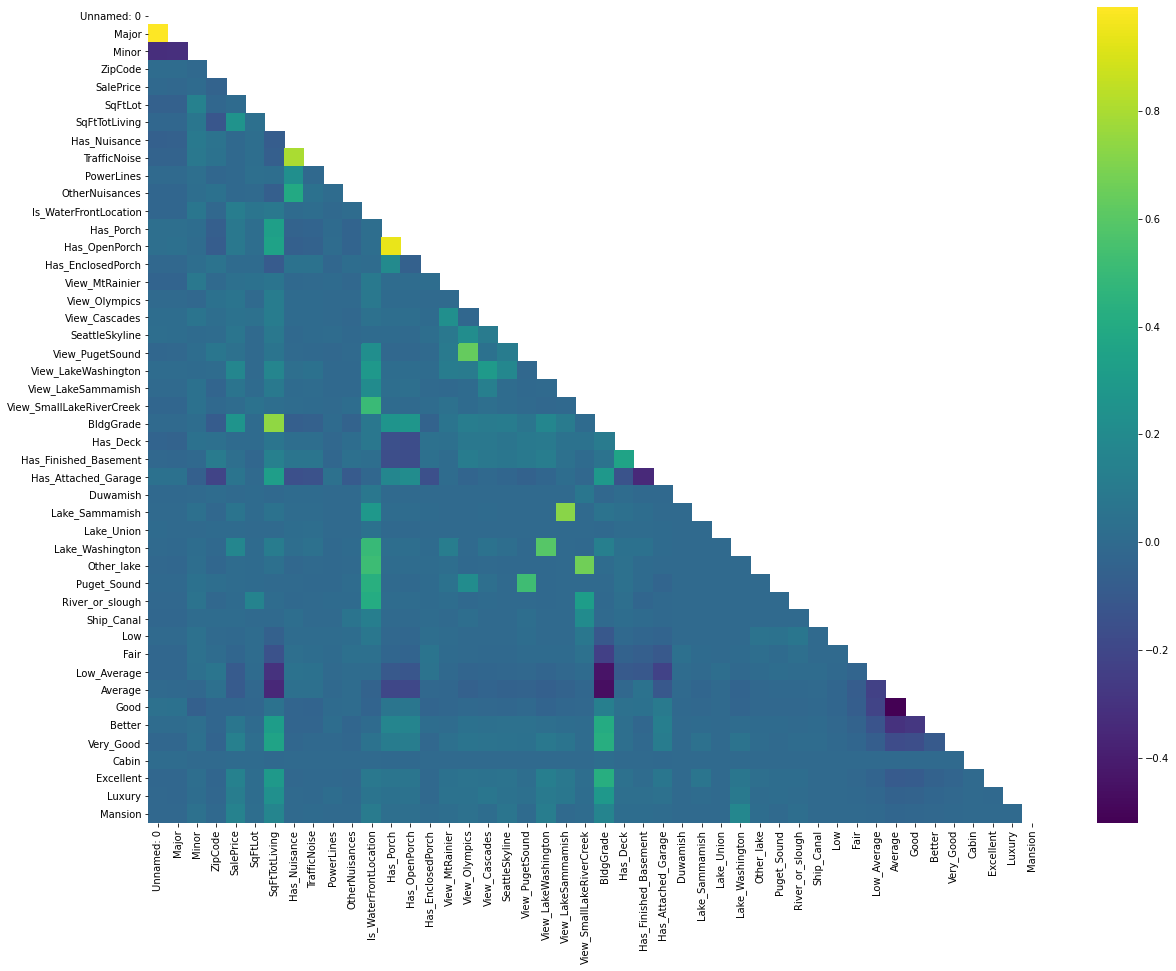

In [62]:
corr = comb_df.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))

fig1, ax1 = plt.subplots(figsize=(20, 15))
sns.heatmap(corr, mask=mask, ax=ax1, cmap="viridis");

In [63]:
corr_matrix = comb_df.corr()
print(corr_matrix["SalePrice"].sort_values(ascending=False))

SalePrice                   1.000000
BldgGrade                   0.263590
SqFtTotLiving               0.255930
Lake_Washington             0.176481
View_LakeWashington         0.175015
Mansion                     0.144607
Excellent                   0.138469
Very_Good                   0.132775
Is_WaterFrontLocation       0.117521
Luxury                      0.117448
Has_OpenPorch               0.083190
Has_Porch                   0.082989
Better                      0.072518
SeattleSkyline              0.066526
View_LakeSammamish          0.064642
Lake_Sammamish              0.063459
View_Olympics               0.063440
Has_Attached_Garage         0.060652
View_Cascades               0.048539
View_PugetSound             0.035875
View_MtRainier              0.032049
Has_Finished_Basement       0.025486
Puget_Sound                 0.010369
View_SmallLakeRiverCreek    0.009317
Ship_Canal                  0.008420
Other_lake                  0.006097
SqFtLot                     0.005337
C

# Multicollinearity check

In [13]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [473]:
X = comb_df[x_cols]
vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
list(zip(x_cols, vif))


[('SqFtTotLiving', 13.558675782637723),
 ('Duwamish', 1.0157177860687998),
 ('Lake_Sammamish', 2.1824306909570885),
 ('Lake_Union', 1.0005514009200183),
 ('Lake_Washington', 1.5779236793798195),
 ('Other_lake', 2.1050751900854623),
 ('Puget_Sound', 1.397852393855669),
 ('River_or_slough', 1.2912920683213598),
 ('Ship_Canal', 1.1060312622867357),
 ('TrafficNoise', 1.146105657520295),
 ('PowerLines', 1.02209169319617),
 ('Has_OpenPorch', 2.565498683539932),
 ('Has_EnclosedPorch', 1.0639770891010045),
 ('View_MtRainier', 1.1117194659202425),
 ('View_Olympics', 1.8868446085054833),
 ('View_Cascades', 1.3128687170422348),
 ('View_PugetSound', 2.3909706157549526),
 ('View_LakeWashington', 1.8564099616126812),
 ('View_LakeSammamish', 2.253330412443031),
 ('View_SmallLakeRiverCreek', 2.504469216483367),
 ('SqFtLot', 1.2726448955635135),
 ('NbrLivingUnits', 15.154090041450024),
 ('BldgGrade', 32.55049750105902),
 ('Has_Deck', 1.9644887195075598)]

In [296]:
#looking for under 5 vif?

In [474]:
#testing with Rainbow test

rainbow_statistic, rainbow_p_value = linear_rainbow(ml_model7)
print("Rainbow statistic:", rainbow_statistic)
print("Rainbow p-value:", rainbow_p_value)

Rainbow statistic: 3.1328814979717152
Rainbow p-value: 0.0


# Normality Check/Q-Q plot


In [14]:
import statsmodels.api as sm
import scipy.stats as stats

#dist=stats.norm
#fit=True

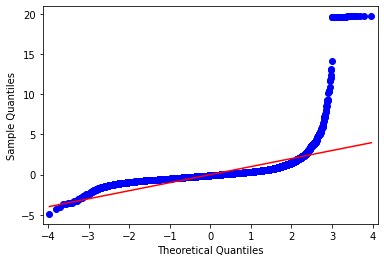

In [475]:
fig = sm.graphics.qqplot(ml_model7.resid, line='s',dist=stats.norm, fit=True)


# Homoscedasticity Check

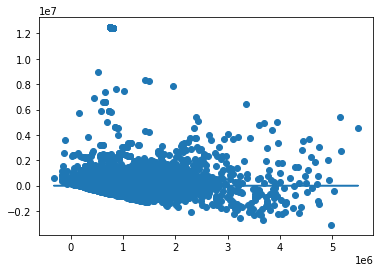

In [476]:
plt.scatter(ml_model7.predict(comb_df[x_cols]), ml_model7.resid)
plt.plot(ml_model7.predict(comb_df[x_cols]), [0 for i in range(len(comb_df))]);

# Model Improvements

### MI_Model1

In [15]:
#MI_Model1: remove not statistically significant inputs based on P-value> .05
#Removing: 'Duwamish', 'Lake_Union', 'River_or_slough', 'Has_OpenPorch', 'View_MtRainier',
#'View_PugetSound''View_Cascades', 'NbrLivingUnits', 'Other_lake'
outcome = 'SalePrice'
x_cols = ['SqFtTotLiving', 'Lake_Sammamish', 
          'Lake_Washington','Puget_Sound', 'Ship_Canal',
         'TrafficNoise', 'PowerLines', 'Has_EnclosedPorch', 'View_Olympics', 
          'View_LakeWashington',
          'View_LakeSammamish','View_SmallLakeRiverCreek', 'SqFtLot', 'BldgGrade', 
          'NbrLivingUnits']


predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
mi_model1 = ols(formula=formula, data=comb_df).fit()
mi_model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.463
Model:                            OLS   Adj. R-squared:                  0.462
Method:                 Least Squares   F-statistic:                     1591.
Date:                Wed, 30 Sep 2020   Prob (F-statistic):               0.00
Time:                        14:44:52   Log-Likelihood:            -3.9983e+05
No. Observations:               27728   AIC:                         7.997e+05
Df Residuals:                   27712   BIC:                         7.998e+05
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                -5.776e+05   2.22e+04    -26.003      0.000   -6.21e+05   -5.34e+05
SqFtTotLiving              182.6437      4.109     44.452      0.000     174.590     190.697
Lake_Sammamish            1.508e+06   1.01e+05     15.001      0.000    1.31e+06     1.7e+06
Lake_Washington            1.23e+06   5.09e+04     24.179      0.000    1.13e+06    1.33e+06
Puget_Sound               2.758e+05   4.79e+04      5.756      0.000    1.82e+05     3.7e+05
Ship_Canal                6.357e+05   1.71e+05      3.718      0.000    3.01e+05    9.71e+05
TrafficNoise              2.546e+04   4822.083      5.279      0.000     1.6e+04    3.49e+04
PowerLines               -9.673e+04   2.61e+04     -3.707      0.000   -1.48e+05   -4.56e+04
Has_EnclosedPorch         8.332e+04   1.27e+04      6.552      0.000    5.84e+04    1.08e+05
View_Olympics             9.878e+04   7059.466     13.992      0.000    8.49e+04    1.13e+05
View_LakeWashington       2.056e+05   8435.812     24.372      0.000    1.89e+05    2.22e+05
View_LakeSammamish        6.236e+04   1.89e+04      3.298      0.001    2.53e+04    9.94e+04
View_SmallLakeRiverCreek  5.479e+04   1.01e+04      5.402      0.000    3.49e+04    7.47e+04
SqFtLot                     -0.2606      0.071     -3.669      0.000      -0.400      -0.121
BldgGrade                 1.551e+05   3252.668     47.674      0.000    1.49e+05    1.61e+05
NbrLivingUnits            5.594e+04    1.6e+04      3.495      0.000    2.46e+04    8.73e+04
==============================================================================
Omnibus:                    28518.718   Durbin-Watson:                   1.037
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          4530883.201
Skew:                           4.790   Prob(JB):                         0.00
Kurtosis:                      64.886   Cond. No.                     2.65e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.65e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
from statsmodels.stats.diagnostic import het_breuschpagan
lm, lm_p_value, fvalue, f_p_value = het_breuschpagan(mi_model1.resid, comb_df[["SalePrice"]])
print("Lagrange Multiplier p-value:", lm_p_value)
print("F-statistic p-value:", f_p_value)

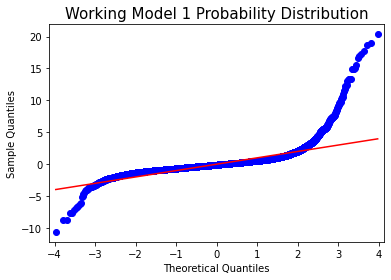

In [17]:
#QQ Plot
fig = sm.graphics.qqplot(mi_model1.resid, line='s',dist=stats.norm, fit=True)
plt.title("Working Model 1 Probability Distribution", fontsize =15);

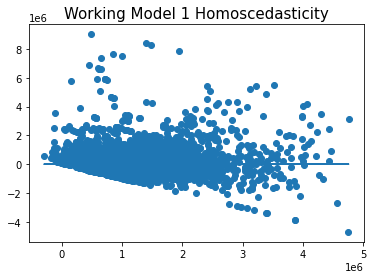

In [19]:
# Homoscedasticity Check
plt.scatter(mi_model1.predict(comb_df[x_cols]), mi_model1.resid)
plt.plot(mi_model1.predict(comb_df[x_cols]), [0 for i in range(len(comb_df))]);
plt.title("Working Model 1 Homoscedasticity", fontsize =15);

In [20]:
# Multicolinearity Check
X = comb_df[x_cols]
vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
list(zip(x_cols, vif))


[('SqFtTotLiving', 12.771817726900414),
 ('Lake_Sammamish', 2.1121660089004677),
 ('Lake_Washington', 1.5287485359965822),
 ('Puget_Sound', 1.0532799795870142),
 ('Ship_Canal', 1.0435122640870407),
 ('TrafficNoise', 1.145971264059955),
 ('PowerLines', 1.020489776520401),
 ('Has_EnclosedPorch', 1.0614223732356407),
 ('View_Olympics', 1.101098838249201),
 ('View_LakeWashington', 1.5972440477181151),
 ('View_LakeSammamish', 2.133281552005733),
 ('View_SmallLakeRiverCreek', 1.0537719460261363),
 ('SqFtLot', 1.2069169247337688),
 ('BldgGrade', 31.592078104031547),
 ('NbrLivingUnits', 15.05094406330874)]

In [21]:
#Rainbw VIF test
rainbow_statistic, rainbow_p_value = linear_rainbow(mi_model1)
print("Rainbow statistic:", rainbow_statistic)
print("Rainbow p-value:", rainbow_p_value)

Rainbow statistic: 1.0228890402922806
Rainbow p-value: 0.09143907094957919


In [ ]:
### MI_Model2

In [523]:
#MI_Model2: remove not statistically significant inputs based on P-value> .05
# taking out because mutlicolinearity high, 'BldgGrade'
outcome = 'SalePrice'
x_cols = ['SqFtTotLiving', 'Lake_Sammamish', 
          'Lake_Washington','Puget_Sound', 'Ship_Canal',
         'TrafficNoise', 'PowerLines', 'Has_EnclosedPorch', 'View_Olympics', 
          'View_PugetSound', 'View_LakeWashington',
          'View_LakeSammamish','View_SmallLakeRiverCreek', 'SqFtLot', 'Has_Deck']


predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
mi_model2 = ols(formula=formula, data=comb_df).fit()
mi_model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.419
Model:                            OLS   Adj. R-squared:                  0.419
Method:                 Least Squares   F-statistic:                     1334.
Date:                Wed, 30 Sep 2020   Prob (F-statistic):               0.00
Time:                        12:02:01   Log-Likelihood:            -4.0090e+05
No. Observations:               27728   AIC:                         8.018e+05
Df Residuals:                   27712   BIC:                         8.020e+05
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                 4.828e+04   7385.352      6.537      0.000    3.38e+04    6.28e+04
SqFtTotLiving              324.2857      2.929    110.714      0.000     318.545     330.027
Lake_Sammamish            1.424e+06   1.04e+05     13.631      0.000    1.22e+06    1.63e+06
Lake_Washington           1.309e+06    5.3e+04     24.722      0.000    1.21e+06    1.41e+06
Puget_Sound               1.718e+05   5.74e+04      2.994      0.003    5.93e+04    2.84e+05
Ship_Canal                6.433e+05   1.78e+05      3.619      0.000    2.95e+05    9.92e+05
TrafficNoise              2.237e+04   5009.003      4.466      0.000    1.26e+04    3.22e+04
PowerLines               -1.053e+05   2.71e+04     -3.880      0.000   -1.58e+05   -5.21e+04
Has_EnclosedPorch         9.994e+04   1.32e+04      7.558      0.000     7.4e+04    1.26e+05
View_Olympics             9.228e+04   9480.315      9.734      0.000    7.37e+04    1.11e+05
View_PugetSound           3.259e+04   1.05e+04      3.108      0.002     1.2e+04    5.31e+04
View_LakeWashington       2.185e+05   8864.235     24.648      0.000    2.01e+05    2.36e+05
View_LakeSammamish        1.077e+05   1.96e+04      5.483      0.000    6.92e+04    1.46e+05
View_SmallLakeRiverCreek   4.58e+04   1.06e+04      4.339      0.000    2.51e+04    6.65e+04
SqFtLot                     -0.3989      0.074     -5.405      0.000      -0.544      -0.254
Has_Deck                  2.833e+04   5635.763      5.027      0.000    1.73e+04    3.94e+04
==============================================================================
Omnibus:                    27022.869   Durbin-Watson:                   1.023
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          3547810.929
Skew:                           4.418   Prob(JB):                         0.00
Kurtosis:                      57.706   Cond. No.                     2.65e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.65e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

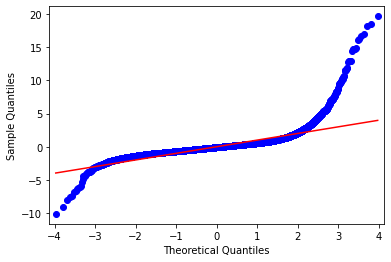

In [524]:
#QQ Plot
fig = sm.graphics.qqplot(mi_model2.resid, line='s',dist=stats.norm, fit=True)


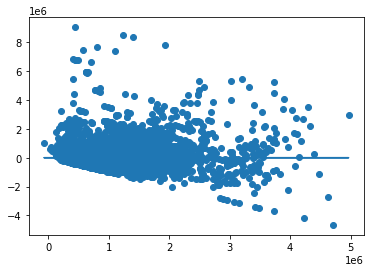

In [525]:
# Homoscedasticity Check
plt.scatter(mi_model2.predict(comb_df[x_cols]), mi_model2.resid)
plt.plot(mi_model2.predict(comb_df[x_cols]), [0 for i in range(len(comb_df))]);

In [526]:
# Multicolinearity Check VIF stats model
X = comb_df[x_cols]
vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
list(zip(x_cols, vif))


[('SqFtTotLiving', 1.9526595297472085),
 ('Lake_Sammamish', 2.1118651662727013),
 ('Lake_Washington', 1.535112686255076),
 ('Puget_Sound', 1.3974912214965884),
 ('Ship_Canal', 1.0437536468379154),
 ('TrafficNoise', 1.10558212508406),
 ('PowerLines', 1.0202851683817211),
 ('Has_EnclosedPorch', 1.0416054146401965),
 ('View_Olympics', 1.8387872192073609),
 ('View_PugetSound', 2.3334611229652578),
 ('View_LakeWashington', 1.621575432550493),
 ('View_LakeSammamish', 2.1285025105720914),
 ('View_SmallLakeRiverCreek', 1.0563852740260489),
 ('SqFtLot', 1.2075990932865068),
 ('Has_Deck', 1.7229050573440836)]

In [407]:
#looks like taking out the zip code helped the multicollinearity withSqFtTotLiving WITHOUT BuildingGrade

In [527]:
#Rainbw VIF test
rainbow_statistic, rainbow_p_value = linear_rainbow(mi_model2)
print("Rainbow statistic:", rainbow_statistic)
print("Rainbow p-value:", rainbow_p_value)

Rainbow statistic: 1.015538324296818
Rainbow p-value: 0.1820768892471457


In [528]:
#MI_Model3: remove not statistically significant inputs based on P-value> .05
# taking because mutlicolinearity high: ' 'SqFtTotLiving', 
#took out 'SqFtLot' because p value .09 in mi_model3
outcome = 'SalePrice'
x_cols = ['Lake_Sammamish', 
          'Lake_Washington','Puget_Sound', 'Ship_Canal', 'SqFtLot',
         'TrafficNoise', 'PowerLines', 'Has_EnclosedPorch', 'View_Olympics', 
          'View_PugetSound', 'View_LakeWashington',
          'View_LakeSammamish','View_SmallLakeRiverCreek', 'BldgGrade', 'Has_Deck' ]


predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
mi_model3 = ols(formula=formula, data=comb_df).fit()
mi_model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.423
Model:                            OLS   Adj. R-squared:                  0.423
Method:                 Least Squares   F-statistic:                     1356.
Date:                Wed, 30 Sep 2020   Prob (F-statistic):               0.00
Time:                        12:02:30   Log-Likelihood:            -4.0081e+05
No. Observations:               27728   AIC:                         8.016e+05
Df Residuals:                   27712   BIC:                         8.018e+05
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                -7.254e+05   1.36e+04    -53.182      0.000   -7.52e+05   -6.99e+05
Lake_Sammamish             1.51e+06   1.04e+05     14.500      0.000    1.31e+06    1.71e+06
Lake_Washington           1.174e+06   5.28e+04     22.225      0.000    1.07e+06    1.28e+06
Puget_Sound               1.512e+05   5.72e+04      2.644      0.008    3.91e+04    2.63e+05
Ship_Canal                 5.64e+05   1.77e+05      3.184      0.001    2.17e+05    9.11e+05
SqFtLot                      0.1946      0.073      2.673      0.008       0.052       0.337
TrafficNoise              1.758e+04   4989.085      3.524      0.000    7804.036    2.74e+04
PowerLines               -8.563e+04    2.7e+04     -3.167      0.002   -1.39e+05   -3.26e+04
Has_EnclosedPorch         3.517e+04   1.31e+04      2.677      0.007    9420.493    6.09e+04
View_Olympics             9.487e+04   9446.769     10.043      0.000    7.64e+04    1.13e+05
View_PugetSound           3.108e+04   1.05e+04      2.974      0.003    1.06e+04    5.16e+04
View_LakeWashington       2.313e+05   8820.514     26.226      0.000    2.14e+05    2.49e+05
View_LakeSammamish        7.592e+04   1.96e+04      3.872      0.000    3.75e+04    1.14e+05
View_SmallLakeRiverCreek  6.467e+04   1.05e+04      6.147      0.000     4.4e+04    8.53e+04
BldgGrade                 2.592e+05   2316.237    111.924      0.000    2.55e+05    2.64e+05
Has_Deck                  1056.2277   5630.110      0.188      0.851   -9979.066    1.21e+04
==============================================================================
Omnibus:                    27808.074   Durbin-Watson:                   1.066
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          3632107.769
Skew:                           4.652   Prob(JB):                         0.00
Kurtosis:                      58.292   Cond. No.                     2.65e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.65e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

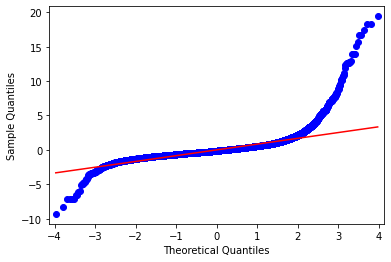

In [563]:
#QQ Plot
fig = sm.graphics.qqplot(mi_model3.resid, line='r',dist=stats.norm, fit=True)

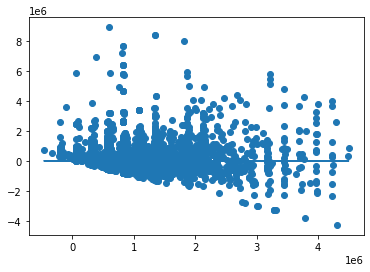

In [530]:
# Homoscedasticity Check
plt.scatter(mi_model3.predict(comb_df[x_cols]), mi_model3.resid)
plt.plot(mi_model3.predict(comb_df[x_cols]), [0 for i in range(len(comb_df))]);
plt.title("Working Model 2 Correlation", fontsize =20);

In [531]:
# Multicolinearity Check
X = comb_df[x_cols]
vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
list(zip(x_cols, vif))


[('Lake_Sammamish', 2.1117795727551076),
 ('Lake_Washington', 1.5350683528802933),
 ('Puget_Sound', 1.396833747605746),
 ('Ship_Canal', 1.043712128386967),
 ('SqFtLot', 1.1832802992786235),
 ('TrafficNoise', 1.1252718391663707),
 ('PowerLines', 1.020786442710718),
 ('Has_EnclosedPorch', 1.049284556788397),
 ('View_Olympics', 1.8364960989274763),
 ('View_PugetSound', 2.3331692776642665),
 ('View_LakeWashington', 1.613922050716701),
 ('View_LakeSammamish', 2.1258326723638765),
 ('View_SmallLakeRiverCreek', 1.0561064874311508),
 ('BldgGrade', 2.13326051076359),
 ('Has_Deck', 1.874417760314171)]

In [532]:
#Rainbw VIF test
rainbow_statistic, rainbow_p_value = linear_rainbow(mi_model3)
print("Rainbow statistic:", rainbow_statistic)
print("Rainbow p-value:", rainbow_p_value)

Rainbow statistic: 1.019644022687316
Rainbow p-value: 0.1261169566075896


In [533]:
corr_df = comb_df[['SalePrice','Lake_Sammamish', 
          'Lake_Washington','Puget_Sound', 'Ship_Canal', 'SqFtLot', 'SqFtTotLiving',
         'TrafficNoise', 'PowerLines', 'Has_EnclosedPorch', 'Has_Deck', 'View_Olympics', 
          'View_PugetSound', 'View_LakeWashington',
          'View_LakeSammamish','View_SmallLakeRiverCreek', 'BldgGrade']]
corr_df.head()

,SalePrice,Lake_Sammamish,Lake_Washington,Puget_Sound,Ship_Canal,SqFtLot,SqFtTotLiving,TrafficNoise,PowerLines,Has_EnclosedPorch,Has_Deck,View_Olympics,View_PugetSound,View_LakeWashington,View_LakeSammamish,View_SmallLakeRiverCreek,BldgGrade
0,310800,0,0,0,0,17400,2240,0,0,0,0,0,0,0,0,0,6
1,339000,0,0,0,0,14500,1200,0,0,0,0,0,0,0,0,0,5
2,485500,0,0,0,0,6002,2134,0,0,0,0,0,0,0,0,0,5
3,850000,0,0,0,0,24142,3500,0,0,0,1,0,0,0,0,0,6
4,535000,0,0,0,0,14208,2170,1,0,0,1,0,0,0,0,0,5


In [22]:
corr = corr_df.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))

fig1, ax1 = plt.subplots(figsize=(11, 9))
sns.heatmap(corr, mask=mask, ax=ax1, cmap="viridis");

plt.title("Working Model 1 Correlation", fontsize =20);
fig1.savefig('corr_model2.jpeg')
#annot=True,

NameError: name 'corr_df' is not defined

In [ ]:
corr = corr_df.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))

fig1, ax1 = plt.subplots(figsize=(11, 9))
sns.heatmap(corr, mask=mask, ax=ax1, cmap="viridis");

In [64]:
corr_matrix = comb_df.corr()
print(corr_matrix["SalePrice"].sort_values(ascending=False))


SalePrice                   1.000000
BldgGrade                   0.263590
SqFtTotLiving               0.255930
Lake_Washington             0.176481
View_LakeWashington         0.175015
Mansion                     0.144607
Excellent                   0.138469
Very_Good                   0.132775
Is_WaterFrontLocation       0.117521
Luxury                      0.117448
Has_OpenPorch               0.083190
Has_Porch                   0.082989
Better                      0.072518
SeattleSkyline              0.066526
View_LakeSammamish          0.064642
Lake_Sammamish              0.063459
View_Olympics               0.063440
Has_Attached_Garage         0.060652
View_Cascades               0.048539
View_PugetSound             0.035875
View_MtRainier              0.032049
Has_Finished_Basement       0.025486
Puget_Sound                 0.010369
View_SmallLakeRiverCreek    0.009317
Ship_Canal                  0.008420
Other_lake                  0.006097
SqFtLot                     0.005337
C

In [79]:
#MI_Model 4 based on top 
outcome = 'SalePrice'
x_cols = ['BldgGrade', 'SqFtTotLiving', 'Lake_Washington', 'View_LakeWashington', 'Mansion', 'Excellent', 'Very_Good', 'Luxury']
          #'Has_OpenPorch', 'Has_Porch', 'Better', 'SeattleSkyline', 'View_LakeSammamish', 'Lake_Sammamish', 'View_Olympics', 'Has_Attached_Garage']
    

          #,'Puget_Sound', 'Ship_Canal', 'SqFtLot',
         #'TrafficNoise', 'PowerLines', 'Has_EnclosedPorch', , 
          #'View_PugetSound', ,
          #,'View_SmallLakeRiverCreek', , 'Has_Deck' ]
            
            #REmoved:
            # high p-value 'Is_WaterFrontLocation'


predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
mi_model4 = ols(formula=formula, data=comb_df).fit()
mi_model4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.111
Model:                            OLS   Adj. R-squared:                  0.111
Method:                 Least Squares   F-statistic:                     437.3
Date:                Thu, 01 Oct 2020   Prob (F-statistic):               0.00
Time:                        08:07:11   Log-Likelihood:            -4.3298e+05
No. Observations:               28009   AIC:                         8.660e+05
Df Residuals:                   28000   BIC:                         8.660e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept           -5551.0283   4.93e+04     -0.113      0.910   -1.02e+05     9.1e+04
BldgGrade            8.594e+04   1.06e+04      8.075      0.000    6.51e+04    1.07e+05
SqFtTotLiving         150.5845     11.352     13.264      0.000     128.333     172.836
Lake_Washington      1.767e+06   1.41e+05     12.559      0.000    1.49e+06    2.04e+06
View_LakeWashington  2.068e+05   2.35e+04      8.787      0.000    1.61e+05    2.53e+05
Mansion              3.717e+06   2.43e+05     15.271      0.000    3.24e+06    4.19e+06
Excellent            6.357e+05   7.15e+04      8.890      0.000    4.95e+05    7.76e+05
Very_Good            3.062e+05   3.96e+04      7.734      0.000    2.29e+05    3.84e+05
Luxury               1.089e+06   1.21e+05      9.013      0.000    8.52e+05    1.33e+06
==============================================================================
Omnibus:                    56174.311   Durbin-Watson:                   0.511
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        190068732.259
Skew:                          16.473   Prob(JB):                         0.00
Kurtosis:                     405.217   Cond. No.                     7.94e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.94e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

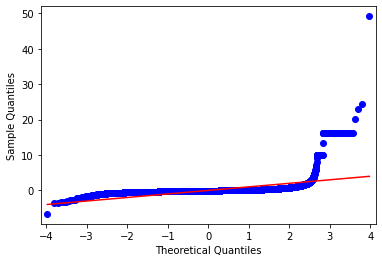

In [80]:
#QQ Plot
fig = sm.graphics.qqplot(mi_model4.resid, line='s',dist=stats.norm, fit=True)

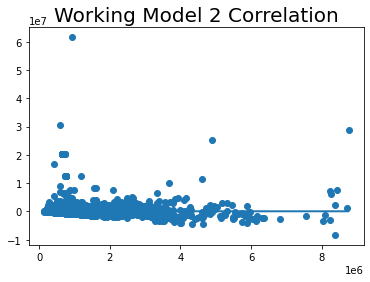

In [81]:
# Homoscedasticity Check
plt.scatter(mi_model4.predict(comb_df[x_cols]), mi_model4.resid)
plt.plot(mi_model4.predict(comb_df[x_cols]), [0 for i in range(len(comb_df))]);
plt.title("Working Model 2 Correlation", fontsize =20);